In [74]:
from IPython.display import HTML

# Quantum Hot Dog, Not Hot Dog

## Video Context


## Background
If you have watched Silicon Valley, you would have come across the SeeFood fracas which made Jian Yang a 'very rich man'. If you haven't essentially, the SeeFood app classifies hot dogs and not hot dogs. For this project, we want to adapt this computer vision algorithm to quantum computers to classify hot dogs and not hot dogs using IBMQ.  

## Overview of Current Direction
To achieve this goal practically, we need to find a way to encode highly dimensional image data to the limited qubit registers available. Subsequently, we need to find an appropriate quantum machine learning algorithm and training algorithm that can be feasibly trained given the time constraints. The final output is essentially a binary classifier. The system will likely involve a combination of quantum and classical approaches.

In [75]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/FNyi3nAuLb0" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)

/Users/jseam/miniconda3/envs/quantum/lib/python3.7/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# Load Libraries

In [76]:
%matplotlib inline

# import relevant libraries
import secret
import os
import pprint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from qiskit import IBMQ
# standard-ish Qiskit libraries
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ

# about transpiling, compiling, and executing
from qiskit.compiler import transpile

# For graphs
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Aer noise models
from qiskit.providers.aer import noise

# Save account if you haven't already done so
IBMQ.save_account(secret.TOKEN)

/Users/jseam/miniconda3/envs/quantum/lib/python3.7/site-packages/qiskit/providers/ibmq/credentials/configrc.py:130: UserWarning: Credentials already present. Set overwrite=True to overwrite.
  warnings.warn('Credentials already present. '


# Sanity checks to see if we are properly connected

In [77]:
# Check if IBMQ is working
IBMQ.load_account()
IBMQ.providers()

/Users/jseam/miniconda3/envs/quantum/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>]

In [78]:
# Get provider and get backends
provider = IBMQ.get_provider(hub='ibm-q')

print('='*81)
print("Simulators")
print('='*81)
pprint.pprint(provider.backends(simulator=True, operational=True))
print()

print('='*81)
print("Real quantum computers")
print('='*81)
pprint.pprint(provider.backends(simulator=False, operational=True))
print()

Simulators
[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>]

Real quantum computers
[<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>]



# Feasibility Study With MNIST
We first study the feasibility of this with MNIST dataset. We will classify 1 and 0 digits for a start.

## Load Data and Sanity Checks

In [79]:
# load data
import tensorflow_datasets as tfds
ds_train, ds_test = tfds.load(name="mnist", split=["train", "test"])

In [80]:
train_0 = []
train_1 = []
train_label = []

test_0 = []
test_1 = []
test_label = []

for example in tfds.as_numpy(ds_train):
    numpy_image, numpy_label = example["image"], example["label"]
    if numpy_label == 0:
        train_0.append(numpy_image.reshape((784)))
        train_label.append(numpy_label)
    
    elif numpy_label == 1:
        train_1.append(numpy_image.reshape((784)))
        train_label.append(numpy_label)

        
    else:
        continue

for example in tfds.as_numpy(ds_test):
    numpy_image, numpy_label = example["image"], example["label"]
    if numpy_label == 0:
        test_0.append(numpy_image.reshape((784)))
        test_label.append(numpy_label)
    
    elif numpy_label == 1:
        test_1.append(numpy_image.reshape((784)))
        test_label.append(numpy_label)

    else:
        continue

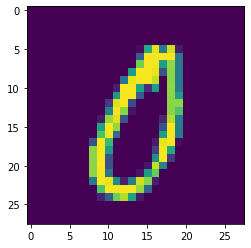

In [81]:
# Sanity Check
pixels = train_0[0]
pixels = pixels.reshape((28,28))
plt.imshow(pixels)

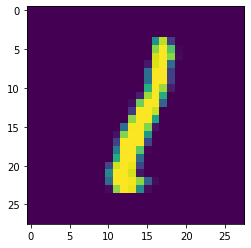

In [82]:
pixels = train_1[0]
pixels = pixels.reshape((28,28))
plt.imshow(pixels)

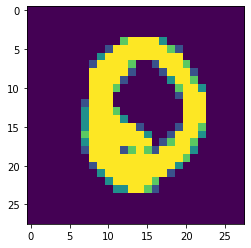

In [83]:
pixels = test_0[0]
pixels = pixels.reshape((28,28))
plt.imshow(pixels)

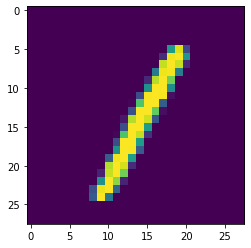

In [84]:
pixels = test_1[0]
pixels = pixels.reshape((28,28))
plt.imshow(pixels)

## Dimensionality Reduction

### Apply PCA

In [85]:
train_all = np.array(train_0 + train_1)
test_all = np.array(test_0 + test_1)

print(train_all.shape)

# Scale images
scaler = StandardScaler()
scaler.fit(train_all)
train_all = scaler.transform(train_all)
test_all = scaler.transform(test_all)

#Apply pca with 0.95 variance
pca = PCA(n_components=50)
pca.fit(train_all)
train_all = pca.transform(train_all)
test_all = pca.transform(test_all)

SyntaxError: invalid syntax (<ipython-input-85-8212154b5d98>, line 12)

### Apply T SNE

In [17]:
train_tsne = TSNE(n_components=2, perplexity=5).fit_transform(train_all)

[ 88.1336    23.28286   72.23721  ... -39.59728   -6.562564 -61.57312 ]
[ 39.23274   -54.114407  -17.357641  ...  11.168255   47.172367
  -3.1950028]


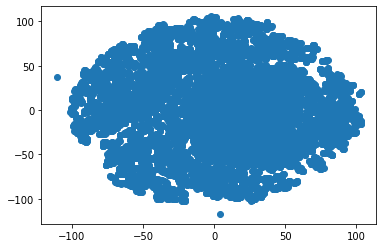

In [22]:
# x, y = np.hsplit(train_tsne, 2)
# x = x.reshape((12665))
# y = y.reshape((12665))
# print(x)
# print(y)
# plt.scatter(x, y, cmap=plt.get_cmap('Spectral'))
# vectors = train_tsne[np.array([item for item in train_label])]

print(train_tsne[:, 0])
print(train_tsne[:, 1])
    
fig, ax = plt.subplots()

# print(train_label)
# for i in len(train_label):
#     if i == 100:
#         break
#     else:
#         ax.scatter(x, y, c=color, s=scale, label=color,
#                alpha=0.3, edgecolors='none')

plt.scatter(
    train_tsne[:, 0], train_tsne[:, 1], cmap=plt.get_cmap('Spectral'))



# Quantum Circuit For Classification

In [86]:
train_0_new = np.array(train_0)
train_1_new = np.array(train_1)

test_0_new = np.array(test_0)
test_1_new = np.array(test_1)

# Scale images
scaler = StandardScaler()
scaler.fit(train_0_new)
train_0_new = scaler.transform(train_0_new)
train_1_new = scaler.transform(train_1_new)
test_0_new = scaler.transform(test_0_new)
test_1_new = scaler.transform(test_1_new)

# Apply pca with 0.95 variance
pca = PCA(n_components=2)
pca.fit(train_0_new)
train_0_new = pca.transform(train_0_new)
train_1_new = pca.transform(train_1_new)
test_0_new = pca.transform(test_0_new)
test_1_new = pca.transform(test_1_new)

In [87]:
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import run_algorithm, QuantumInstance

In [102]:
training_dataset_size = 20
testing_dataset_size = 10
random_seed = 10598
shots = 1024

train_0_final = train_0_new[:training_dataset_size]
train_1_final = train_1_new[:training_dataset_size]

print(train_0_final.shape)
print(train_1_final.shape)

test_0_final = test_0_new[:testing_dataset_size]
test_1_final = test_1_new[:testing_dataset_size]

print(test_0_final.shape)
print(test_1_final.shape)


train_dataset = {'0': train_0_final, 
                 '1': train_1_final}
                                        
test_dataset = {'0': test_0_final, 
                '1': test_1_final}

class_name = {'0': 0, '1': 1}

train_datapoints, class_to_label_train = split_dataset_to_data_and_labels(train_dataset, class_name)
test_datapoints, class_to_label_test = split_dataset_to_data_and_labels(test_dataset, class_name)

print(class_to_label_train)
print(class_to_label_test)



# backend = IBMQ.backend('qasm_simulator')             
backend = Aer.get_backend('qasm_simulator')

feature_map = SecondOrderExpansion(2, depth=2)
svm = QSVM(feature_map, train_dataset, test_dataset, None)# the data for prediction can be feeded later.
svm.random_seed = random_seed
quantum_instance = QuantumInstance(backend, shots=shots)
result = svm.run(quantum_instance)

(20, 2)
(20, 2)
(10, 2)
(10, 2)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [103]:
result['testing_accuracy']

0.75

In [104]:
result

{'kernel_matrix_training': array([[1.        , 0.45117188, 0.18554688, ..., 0.14746094, 0.25683594,
         0.69824219],
        [0.45117188, 1.        , 0.06933594, ..., 0.0546875 , 0.69726562,
         0.14941406],
        [0.18554688, 0.06933594, 1.        , ..., 0.17480469, 0.03710938,
         0.50683594],
        ...,
        [0.14746094, 0.0546875 , 0.17480469, ..., 1.        , 0.18066406,
         0.2578125 ],
        [0.25683594, 0.69726562, 0.03710938, ..., 0.18066406, 1.        ,
         0.07910156],
        [0.69824219, 0.14941406, 0.50683594, ..., 0.2578125 , 0.07910156,
         1.        ]]),
 'svm': {'alphas': array([ 66.26586732,  15.71611356, 142.76241023,  34.83108145,
          27.3775359 , 104.11939902,  21.28407541,  51.03165762,
          40.45933669,   7.30447064,  22.21748832,  35.6237549 ,
          25.01715257, 112.11343269,  14.60533859,  25.88208686,
          24.67478081,   7.33720858,   7.48378455,  96.45178211,
          97.29171955,  32.5783123 ,   6.

# Hot Dog / Not Hot Dog

## Step 1: Finding Images
In order to do the task we first need to find images of hot dogs and not hot dogs. Thankfully, there is a kaggle dataset that had already done this for us :)

[Hot Dog Not Hot Dog](https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog)


## Step 2: Processing Images
Next, we need to process the images available on the dataset. Let's check how the images are like.